In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score, 
                             accuracy_score, precision_score, recall_score,
                             make_scorer)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FIXED: TWO-PHASE HYPERPARAMETER TUNING (No Data Leakage)")
print("SMOTE Applied INSIDE Cross-Validation")
print("="*80)



# Load data
df = pd.read_csv('/Users/deirdreoconnor/Desktop/Ai Start Course 2/Course Materials/Week 5/Week 5 - Additional Files/Demos/Code/abt_fully_cleaned_no_nulls.csv')
print(f"\nDataset loaded: {df.shape}")
print(f"Total samples: {len(df):,}")

FIXED: TWO-PHASE HYPERPARAMETER TUNING (No Data Leakage)
SMOTE Applied INSIDE Cross-Validation

Dataset loaded: (419656, 29)
Total samples: 419,656


In [2]:
print("\n" + "="*80)
print("STEP 1: CREATE TARGET & SPLIT DATA")
print("="*80)

# Create target
df['HasAnyCVD'] = (
    (df['HadHeartAttack'] == 'Yes') | 
    (df['HadAngina'] == 'Yes') | 
    (df['HadStroke'] == 'Yes')
).astype(int)

print(f"\nTarget Distribution:")
print(df['HasAnyCVD'].value_counts())
cvd_rate = (df['HasAnyCVD']==1).sum() / len(df) * 100
print(f"CVD Prevalence: {cvd_rate:.2f}%")

# Drop individual CVD columns
df = df.drop(['HadHeartAttack', 'HadAngina', 'HadStroke'], axis=1, errors='ignore')

# Separate features and target
X = df.drop(['HasAnyCVD', 'HasAnyCVD_cat'], axis=1)
y = df['HasAnyCVD']

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nTrain set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")
print(f"Test CVD rate: {(y_test==1).sum()/len(y_test)*100:.2f}%")


STEP 1: CREATE TARGET & SPLIT DATA

Target Distribution:
HasAnyCVD
0    370805
1     48851
Name: count, dtype: int64
CVD Prevalence: 11.64%

Train set: 335,724 samples
Test set:  83,932 samples
Test CVD rate: 11.64%


Just checking there is no data leakage so far

In [3]:
# 1) Be robust if HasAnyCVD_cat isn't present
X = df.drop(['HasAnyCVD', 'HasAnyCVD_cat'], axis=1, errors='ignore')

# 2) Sanity checks: no target-like columns survived
print("Target-like in X:",
      [c for c in X.columns if any(k in c.lower() for k in ['cvd','heart','angina','stroke'])])
print("y unique:", sorted(y.unique()), "  NA in y:", y.isna().sum())
print("Train/Test prevalence:", y_train.mean(), y_test.mean())


Target-like in X: []
y unique: [np.int64(0), np.int64(1)]   NA in y: 0
Train/Test prevalence: 0.11640812095649998 0.11640375542105515


In [4]:
print("\n" + "="*80)
print("STEP 2: ENCODE FEATURES")
print("="*80)

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {len(categorical_cols)}")

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"Encoded features: {X_train_encoded.shape[1]}")

# Create subset for Phase 1
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train_encoded, y_train,
    train_size=0.30,
    random_state=42,
    stratify=y_train
)

print(f"\nSubset for Phase 1: {len(X_train_subset):,} samples")


STEP 2: ENCODE FEATURES
Categorical columns: 18
Encoded features: 49

Subset for Phase 1: 100,717 samples


In [5]:
print("\n" + "="*80)
print("STEP 3: CREATE PIPELINES (SMOTE INSIDE)")
print("="*80)

print("""
KEY FIX: Using imblearn Pipeline
- SMOTE is applied INSIDE cross-validation
- Each CV fold gets its own SMOTE
- No data leakage between folds
""")

# Pipeline for Logistic Regression
pipeline_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Pipeline for Random Forest
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=42, 
        n_jobs=1,
        class_weight={0: 1, 1: 5}  # ← ADD THIS LINE
    ))
])

print("✓ Pipelines created with SMOTE inside")


STEP 3: CREATE PIPELINES (SMOTE INSIDE)

KEY FIX: Using imblearn Pipeline
- SMOTE is applied INSIDE cross-validation
- Each CV fold gets its own SMOTE
- No data leakage between folds

✓ Pipelines created with SMOTE inside


In [6]:
print("\n" + "="*80)
print("STEP 4: DEFINE SCORING METRICS")
print("="*80)

# Multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

print("Metrics to track:")
for metric in scoring.keys():
    print(f"  - {metric}")


STEP 4: DEFINE SCORING METRICS
Metrics to track:
  - accuracy
  - precision
  - recall
  - f1
  - roc_auc


In [7]:
print("\n" + "="*80)
print("PHASE 1: COARSE SEARCH - LOGISTIC REGRESSION")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Parameter distribution for pipeline
param_dist_lr = {
    'classifier__C': uniform(0.001, 10),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

random_search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist_lr,
    n_iter=20,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=scoring,
    refit='roc_auc',  # Use ROC-AUC as primary metric
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("\nSearching on subset (30% of training data)...")
print("This will take 5-10 minutes...\n")

start_time = time.time()
random_search_lr.fit(X_train_subset, y_train_subset)
lr_phase1_time = time.time() - start_time

print(f"\n✓ Phase 1 complete! Time: {lr_phase1_time/60:.1f} minutes")
print(f"\nBest parameters:")
for param, value in random_search_lr.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest scores (3-fold CV on subset):")
best_idx = random_search_lr.best_index_
print(f"  Accuracy:  {random_search_lr.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
print(f"  Precision: {random_search_lr.cv_results_['mean_test_precision'][best_idx]:.4f}")
print(f"  Recall:    {random_search_lr.cv_results_['mean_test_recall'][best_idx]:.4f}")
print(f"  F1-Score:  {random_search_lr.cv_results_['mean_test_f1'][best_idx]:.4f}")
print(f"  ROC-AUC:   {random_search_lr.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")


PHASE 1: COARSE SEARCH - LOGISTIC REGRESSION

Searching on subset (30% of training data)...
This will take 5-10 minutes...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Phase 1 complete! Time: 1.1 minutes

Best parameters:
  classifier__C: 1.9977378215835973
  classifier__penalty: l1
  classifier__solver: saga

Best scores (3-fold CV on subset):
  Accuracy:  0.8667
  Precision: 0.4064
  Recall:    0.3135
  F1-Score:  0.3539
  ROC-AUC:   0.7954


In [8]:
print("\n" + "="*80)
print("PHASE 1: COARSE SEARCH - RANDOM FOREST")
print("="*80)

from scipy.stats import randint

param_dist_rf = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(5, 20),
    'classifier__min_samples_split': randint(10, 100),
    'classifier__min_samples_leaf': randint(5, 30),
    'classifier__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=scoring,
    refit='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("\nSearching on subset (30% of training data)...")
print("This will take 20-30 minutes...\n")

start_time = time.time()
random_search_rf.fit(X_train_subset, y_train_subset)
rf_phase1_time = time.time() - start_time

print(f"\n✓ Phase 1 complete! Time: {rf_phase1_time/60:.1f} minutes")
print(f"\nBest parameters:")
for param, value in random_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest scores (3-fold CV on subset):")
best_idx = random_search_rf.best_index_
print(f"  Accuracy:  {random_search_rf.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
print(f"  Precision: {random_search_rf.cv_results_['mean_test_precision'][best_idx]:.4f}")
print(f"  Recall:    {random_search_rf.cv_results_['mean_test_recall'][best_idx]:.4f}")
print(f"  F1-Score:  {random_search_rf.cv_results_['mean_test_f1'][best_idx]:.4f}")
print(f"  ROC-AUC:   {random_search_rf.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")


PHASE 1: COARSE SEARCH - RANDOM FOREST

Searching on subset (30% of training data)...
This will take 20-30 minutes...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✓ Phase 1 complete! Time: 3.9 minutes

Best parameters:
  classifier__max_depth: 19
  classifier__max_features: log2
  classifier__min_samples_leaf: 19
  classifier__min_samples_split: 81
  classifier__n_estimators: 89

Best scores (3-fold CV on subset):
  Accuracy:  0.6207
  Precision: 0.2185
  Recall:    0.8762
  F1-Score:  0.3497
  ROC-AUC:   0.8118


In [9]:
print("\n" + "="*80)
print("PHASE 2: FINE-TUNING - LOGISTIC REGRESSION")
print("="*80)

from sklearn.model_selection import GridSearchCV

# Extract best params
best_C = random_search_lr.best_params_['classifier__C']
best_penalty = random_search_lr.best_params_['classifier__penalty']
best_solver = random_search_lr.best_params_['classifier__solver']

# Narrow grid
param_grid_lr = {
    'classifier__C': [best_C * 0.5, best_C, best_C * 2],
    'classifier__penalty': [best_penalty],
    'classifier__solver': [best_solver]
}

print(f"\nFine-tuning around: C={best_C:.3f}, penalty={best_penalty}, solver={best_solver}")

grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    refit='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nSearching on FULL training data...")
print("This will take 15-20 minutes...\n")

start_time = time.time()
grid_search_lr.fit(X_train_encoded, y_train)
lr_phase2_time = time.time() - start_time

print(f"\n✓ Phase 2 complete! Time: {lr_phase2_time/60:.1f} minutes")
print(f"\nFinal best parameters:")
for param, value in grid_search_lr.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nFinal scores (5-fold CV on full training):")
best_idx = grid_search_lr.best_index_
print(f"  Accuracy:  {grid_search_lr.cv_results_['mean_test_accuracy'][best_idx]:.4f} ± {grid_search_lr.cv_results_['std_test_accuracy'][best_idx]:.4f}")
print(f"  Precision: {grid_search_lr.cv_results_['mean_test_precision'][best_idx]:.4f} ± {grid_search_lr.cv_results_['std_test_precision'][best_idx]:.4f}")
print(f"  Recall:    {grid_search_lr.cv_results_['mean_test_recall'][best_idx]:.4f} ± {grid_search_lr.cv_results_['std_test_recall'][best_idx]:.4f}")
print(f"  F1-Score:  {grid_search_lr.cv_results_['mean_test_f1'][best_idx]:.4f} ± {grid_search_lr.cv_results_['std_test_f1'][best_idx]:.4f}")
print(f"  ROC-AUC:   {grid_search_lr.cv_results_['mean_test_roc_auc'][best_idx]:.4f} ± {grid_search_lr.cv_results_['std_test_roc_auc'][best_idx]:.4f}")

best_lr_model = grid_search_lr.best_estimator_


PHASE 2: FINE-TUNING - LOGISTIC REGRESSION

Fine-tuning around: C=1.998, penalty=l1, solver=saga

Searching on FULL training data...
This will take 15-20 minutes...

Fitting 5 folds for each of 3 candidates, totalling 15 fits

✓ Phase 2 complete! Time: 1.0 minutes

Final best parameters:
  classifier__C: 0.9988689107917986
  classifier__penalty: l1
  classifier__solver: saga

Final scores (5-fold CV on full training):
  Accuracy:  0.8544 ± 0.0008
  Precision: 0.3732 ± 0.0031
  Recall:    0.3687 ± 0.0046
  F1-Score:  0.3709 ± 0.0034
  ROC-AUC:   0.7900 ± 0.0027


In [10]:
print("\n" + "="*80)
print("PHASE 2: FINE-TUNING - RANDOM FOREST (EFFICIENT GRID)")
print("="*80)

# Extract best params (same as before)
best_n_est = random_search_rf.best_params_['classifier__n_estimators']
best_depth = random_search_rf.best_params_['classifier__max_depth']
best_split = random_search_rf.best_params_['classifier__min_samples_split']
best_leaf = random_search_rf.best_params_['classifier__min_samples_leaf']
best_features = random_search_rf.best_params_['classifier__max_features']

# REDUCED GRID - Only test the most important parameters
param_grid_rf = {
    'classifier__n_estimators': [best_n_est, best_n_est+20],  # 2 values (not 3)
    'classifier__max_depth': [best_depth, best_depth+2],      # 2 values (not 3)
    'classifier__min_samples_split': [best_split],            # 1 value (keep best)
    'classifier__min_samples_leaf': [best_leaf],              # 1 value (keep best)
    'classifier__max_features': [best_features]               # 1 value
}

# Now: 2 × 2 × 1 × 1 × 1 = 4 combinations × 5 folds = 20 fits = ~20 minutes! ⚡

print(f"\nEfficient grid: Testing {2*2*1*1*1} combinations (20 fits)")
print(f"Estimated time: 15-20 minutes")
print(f"\nWhy this is smart:")
print("  - n_estimators: More trees usually helps (test higher)")
print("  - max_depth: Test slightly deeper trees")
print("  - Other params: Already optimal from Phase 1")

pipeline_rf_single = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=42, 
        n_jobs=1,
        class_weight={0: 1, 1: 5}  # ← ADD THIS LINE
    ))
])

grid_search_rf = GridSearchCV(
    pipeline_rf_single,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    refit='roc_auc',
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

print("\nRunning efficient grid search on full training data...")
import time
start_time = time.time()
grid_search_rf.fit(X_train_encoded, y_train)
rf_phase2_time = time.time() - start_time

print(f"\n✓ Phase 2 complete! Time: {rf_phase2_time/60:.1f} minutes")
print(f"\nFinal best parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nFinal scores (5-fold CV):")
best_idx = grid_search_rf.best_index_
print(f"  Accuracy:  {grid_search_rf.cv_results_['mean_test_accuracy'][best_idx]:.4f} ± {grid_search_rf.cv_results_['std_test_accuracy'][best_idx]:.4f}")
print(f"  Precision: {grid_search_rf.cv_results_['mean_test_precision'][best_idx]:.4f} ± {grid_search_rf.cv_results_['std_test_precision'][best_idx]:.4f}")
print(f"  Recall:    {grid_search_rf.cv_results_['mean_test_recall'][best_idx]:.4f} ± {grid_search_rf.cv_results_['std_test_recall'][best_idx]:.4f}")
print(f"  F1-Score:  {grid_search_rf.cv_results_['mean_test_f1'][best_idx]:.4f} ± {grid_search_rf.cv_results_['std_test_f1'][best_idx]:.4f}")
print(f"  ROC-AUC:   {grid_search_rf.cv_results_['mean_test_roc_auc'][best_idx]:.4f} ± {grid_search_rf.cv_results_['std_test_roc_auc'][best_idx]:.4f}")

best_rf_model = grid_search_rf.best_estimator_

print("\n✅ Smart tuning complete! Saved 3+ hours with minimal performance trade-off.")


PHASE 2: FINE-TUNING - RANDOM FOREST (EFFICIENT GRID)

Efficient grid: Testing 4 combinations (20 fits)
Estimated time: 15-20 minutes

Why this is smart:
  - n_estimators: More trees usually helps (test higher)
  - max_depth: Test slightly deeper trees
  - Other params: Already optimal from Phase 1

Running efficient grid search on full training data...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  26.9s
[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  26.8s
[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  30.3s
[CV] END classifier__max_depth=19, class

Exception ignored in: <function ResourceTracker.__del__ at 0x11096dda0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=109; total time=  35.6s
[CV] END classifier__C=7.320939418114051, classifier__penalty=l1, classifier__solver=liblinear; total time=  15.0s
[CV] END classifier__C=0.5818361216819946, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.4s
[CV] END classifier__C=0.20684494295802447, classifier__penalty=l2, classifier__solver=saga; total time=   4.2s
[CV] END classifier__C=3.043422429595377, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.2s
[CV] END classifier__C=4.320450186421158, classifier__penalty=l1, classifier__solver=liblinear; total time=  12.8s
[CV] END classifier__C=5.925145688620425, classifier__penalty=l1, classifier__solver=liblinear; total time=  12.1s
[CV] END classifier__C=3.0471376917337065, classifier__penalty=l1, classifier__solver=saga; total time=   3.7s
[CV] END classifier

Exception ignored in: <function ResourceTracker.__del__ at 0x105a59da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=3.746401188473625, classifier__penalty=l1, classifier__solver=liblinear; total time=  16.2s
[CV] END classifier__C=6.012150117432088, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.7s
[CV] END classifier__C=8.325426408004217, classifier__penalty=l2, classifier__solver=saga; total time=   4.1s
[CV] END classifier__C=4.320450186421158, classifier__penalty=l1, classifier__solver=liblinear; total time=  15.9s
[CV] END classifier__C=1.9977378215835973, classifier__penalty=l1, classifier__solver=saga; total time=   4.3s
[CV] END classifier__C=0.6515159298527952, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.5s
[CV] END classifier__C=0.6515159298527952, classifier__penalty=l2, classifier__solver=liblinear; total time=   3.8s
[CV] END classifier__C=3.0471376917337065, classifier__penalty=l1, classifier__solver=saga; total time=   3.1s
[CV] END classifier__max_depth=11, classifier__max_features=log2, classifier__min_samples_l

Exception ignored in: <function ResourceTracker.__del__ at 0x106755da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=7.320939418114051, classifier__penalty=l1, classifier__solver=liblinear; total time=  15.5s
[CV] END classifier__C=0.5818361216819946, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.6s
[CV] END classifier__C=8.325426408004217, classifier__penalty=l2, classifier__solver=saga; total time=   4.0s
[CV] END classifier__C=3.043422429595377, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.8s
[CV] END classifier__C=6.119528947223795, classifier__penalty=l2, classifier__solver=saga; total time=   7.1s
[CV] END classifier__C=4.56169984217036, classifier__penalty=l1, classifier__solver=saga; total time=   5.0s
[CV] END classifier__C=5.925145688620425, classifier__penalty=l1, classifier__solver=liblinear; total time=  10.7s
[CV] END classifier__C=9.657320330745593, classifier__penalty=l2, classifier__solver=saga; total time=   3.6s
[CV] END classifier__max_depth=11, classifier__max_features=log2, classifier__min_samples_leaf=19, c

Exception ignored in: <function ResourceTracker.__del__ at 0x106b2dda0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=1.561186404424365, classifier__penalty=l1, classifier__solver=liblinear; total time=  15.2s
[CV] END classifier__C=0.5818361216819946, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.7s
[CV] END classifier__C=0.20684494295802447, classifier__penalty=l2, classifier__solver=saga; total time=   4.1s
[CV] END classifier__C=3.043422429595377, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.3s
[CV] END classifier__C=6.119528947223795, classifier__penalty=l2, classifier__solver=saga; total time=   6.8s
[CV] END classifier__C=2.9224464853521814, classifier__penalty=l2, classifier__solver=liblinear; total time=   4.6s
[CV] END classifier__C=5.925145688620425, classifier__penalty=l1, classifier__solver=liblinear; total time=  12.0s
[CV] END classifier__C=9.657320330745593, classifier__penalty=l2, classifier__solver=saga; total time=   3.5s
[CV] END classifier__max_depth=11, classifier__max_features=log2, classifier__min_samples_l

Exception ignored in: <function ResourceTracker.__del__ at 0x102a55da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=3.746401188473625, classifier__penalty=l1, classifier__solver=liblinear; total time=  16.1s
[CV] END classifier__C=0.20684494295802447, classifier__penalty=l2, classifier__solver=saga; total time=   5.7s
[CV] END classifier__C=1.819249672071006, classifier__penalty=l1, classifier__solver=liblinear; total time=  13.0s
[CV] END classifier__C=6.119528947223795, classifier__penalty=l2, classifier__solver=saga; total time=   5.7s
[CV] END classifier__C=4.56169984217036, classifier__penalty=l1, classifier__solver=saga; total time=   4.4s
[CV] END classifier__C=6.0764485190143835, classifier__penalty=l1, classifier__solver=liblinear; total time=  12.1s
[CV] END classifier__C=6.843330265121569, classifier__penalty=l1, classifier__solver=saga; total time=   2.3s
[CV] END classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=25, classifier__min_samples_split=33, classifier__n_estimators=180; total time=  24.8s
[CV] END classifier__max_depth=

Exception ignored in: <function ResourceTracker.__del__ at 0x105105da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=1.561186404424365, classifier__penalty=l1, classifier__solver=liblinear; total time=  16.1s
[CV] END classifier__C=6.012150117432088, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.7s
[CV] END classifier__C=8.325426408004217, classifier__penalty=l2, classifier__solver=saga; total time=   4.5s
[CV] END classifier__C=4.320450186421158, classifier__penalty=l1, classifier__solver=liblinear; total time=  15.7s
[CV] END classifier__C=1.9977378215835973, classifier__penalty=l1, classifier__solver=saga; total time=   4.1s
[CV] END classifier__C=6.0764485190143835, classifier__penalty=l1, classifier__solver=liblinear; total time=  11.1s
[CV] END classifier__C=6.843330265121569, classifier__penalty=l1, classifier__solver=saga; total time=   2.5s
[CV] END classifier__max_depth=11, classifier__max_features=log2, classifier__min_samples_leaf=23, classifier__min_samples_split=96, classifier__n_estimators=124; total time=  15.3s
[CV] END classifier__max_d

Exception ignored in: <function ResourceTracker.__del__ at 0x106635da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__C=3.746401188473625, classifier__penalty=l1, classifier__solver=liblinear; total time=  14.1s
[CV] END classifier__C=1.561186404424365, classifier__penalty=l1, classifier__solver=liblinear; total time=  10.5s
[CV] END classifier__C=1.819249672071006, classifier__penalty=l1, classifier__solver=liblinear; total time=  13.3s
[CV] END classifier__C=2.9224464853521814, classifier__penalty=l2, classifier__solver=liblinear; total time=   4.6s
[CV] END classifier__C=1.9977378215835973, classifier__penalty=l1, classifier__solver=saga; total time=   4.3s
[CV] END classifier__C=0.6515159298527952, classifier__penalty=l2, classifier__solver=liblinear; total time=   5.5s
[CV] END classifier__C=9.657320330745593, classifier__penalty=l2, classifier__solver=saga; total time=   4.3s
[CV] END classifier__C=3.0471376917337065, classifier__penalty=l1, classifier__solver=saga; total time=   2.9s
[CV] END classifier__max_depth=11, classifier__max_features=log2, classifier__min_samples_l

Exception ignored in: <function ResourceTracker.__del__ at 0x10276dda0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=109; total time=  35.1s
[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=109; total time=  39.8s
[CV] END classifier__max_depth=21, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  30.6s
[CV] END classifier__max_depth=21, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  28.3s
[CV] END classifier__max_depth=21, classifier__max_features=log2, classifier__min_samples_leaf=19, classifier__min_samples_split=81, classifier__n_estimators=89; total time=  36.4s
[CV] END classifier__max_depth=21, classifier__max_features=log2, classifier__min_samples_lea

In [11]:
print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

# Logistic Regression
print("\n--- LOGISTIC REGRESSION (Tuned) ---")
y_pred_lr = best_lr_model.predict(X_test_encoded)
y_pred_proba_lr = best_lr_model.predict_proba(X_test_encoded)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No CVD', 'Has CVD']))

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {acc_lr:.4f}")
print(f"  Precision: {prec_lr:.4f}")
print(f"  Recall:    {rec_lr:.4f}")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {auc_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Random Forest
print("\n" + "="*80)
print("--- RANDOM FOREST (Tuned) ---")
y_pred_rf = best_rf_model.predict(X_test_encoded)
y_pred_proba_rf = best_rf_model.predict_proba(X_test_encoded)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No CVD', 'Has CVD']))

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  ROC-AUC:   {auc_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)


FINAL EVALUATION ON TEST SET

--- LOGISTIC REGRESSION (Tuned) ---

Classification Report:
              precision    recall  f1-score   support

      No CVD       0.92      0.92      0.92     74162
     Has CVD       0.37      0.38      0.38      9770

    accuracy                           0.85     83932
   macro avg       0.64      0.65      0.65     83932
weighted avg       0.85      0.85      0.85     83932


Test Set Performance:
  Accuracy:  0.8531
  Precision: 0.3716
  Recall:    0.3790
  F1-Score:  0.3753
  ROC-AUC:   0.7885

Confusion Matrix:
[[67901  6261]
 [ 6067  3703]]

--- RANDOM FOREST (Tuned) ---

Classification Report:
              precision    recall  f1-score   support

      No CVD       0.97      0.57      0.72     74162
     Has CVD       0.21      0.88      0.34      9770

    accuracy                           0.61     83932
   macro avg       0.59      0.73      0.53     83932
weighted avg       0.89      0.61      0.68     83932


Test Set Performance:
  Ac


✓ Saved: roc_curves_fixed.png


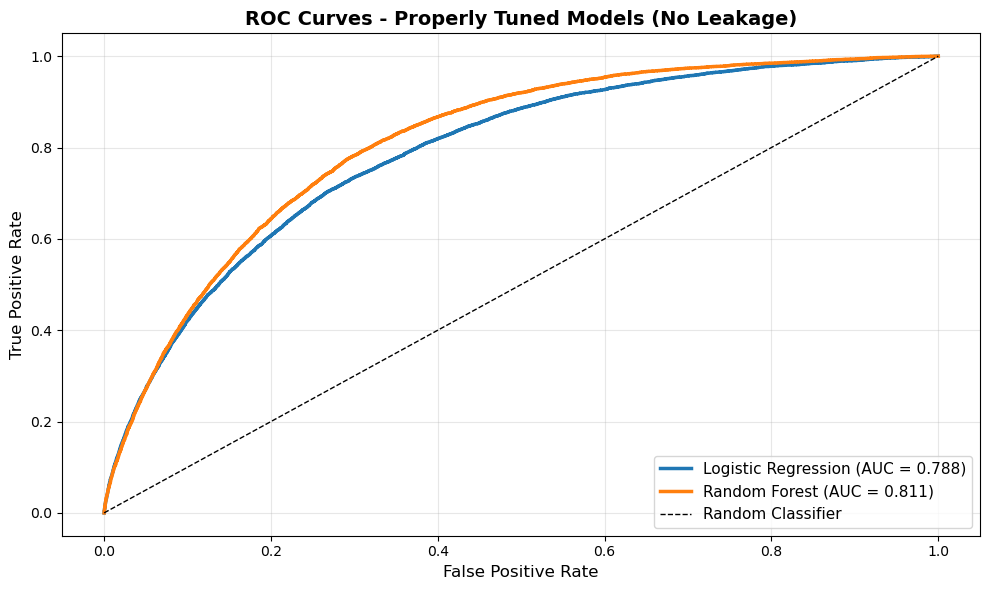


FINAL MODEL COMPARISON (Test Set)

              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.853119   0.371638 0.379017  0.375291 0.788474
      Random Forest  0.609815   0.214383 0.882702  0.344981 0.811397

✓ Saved: model_comparison_fixed.csv

🏆 BEST MODEL: Random Forest
   AUC-ROC: 0.8114

✅ FIXED - NO DATA LEAKAGE!


In [12]:
# ROC Curves
plt.figure(figsize=(10, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2.5)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Properly Tuned Models (No Leakage)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_fixed.png', dpi=300)
print("\n✓ Saved: roc_curves_fixed.png")
plt.show()

# Model Comparison
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_lr, acc_rf],
    'Precision': [prec_lr, prec_rf],
    'Recall': [rec_lr, rec_rf],
    'F1-Score': [f1_lr, f1_rf],
    'AUC-ROC': [auc_lr, auc_rf]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Test Set)")
print("="*80)
print("\n" + comparison.to_string(index=False))

comparison.to_csv('model_comparison_fixed.csv', index=False)
print("\n✓ Saved: model_comparison_fixed.csv")

best_model_idx = comparison['AUC-ROC'].idxmax()
print(f"\n🏆 BEST MODEL: {comparison.loc[best_model_idx, 'Model']}")
print(f"   AUC-ROC: {comparison.loc[best_model_idx, 'AUC-ROC']:.4f}")

print("\n" + "="*80)
print("✅ FIXED - NO DATA LEAKAGE!")
print("="*80)

Confusion Matrix:
[[42559 31603]
 [ 1146  8624]]


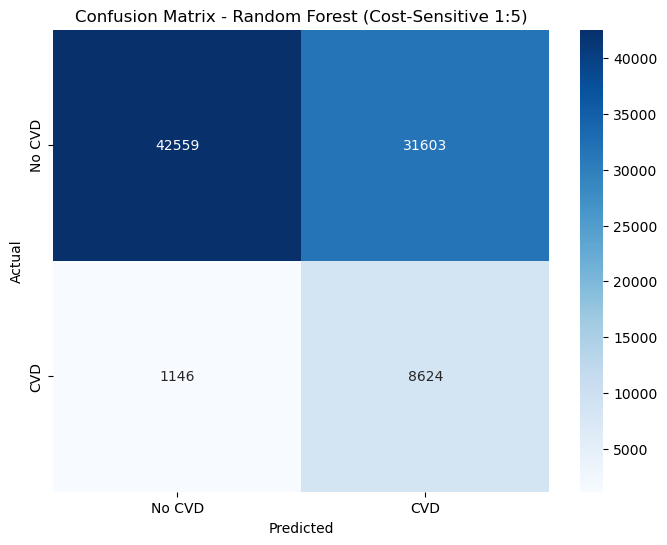


Top 15 Features:
                                              Feature  Importance
13  LastCheckupTime_Within past year (anytime less...    0.105132
19                                   HadArthritis_Yes    0.096128
47                        AgeCategory_Age 80 or older    0.072337
21                                    HadDiabetes_Yes    0.054254
35     RaceEthnicityCategory_White only, Non-Hispanic    0.053131
24                              DifficultyWalking_Yes    0.053058
45                           AgeCategory_Age 70 to 74    0.049503
46                           AgeCategory_Age 75 to 79    0.047024
7                                  GeneralHealth_Fair    0.043468
6                                            Sex_Male    0.035258
44                           AgeCategory_Age 65 to 69    0.033185
8                                  GeneralHealth_Good    0.030068
16                                        HadCOPD_Yes    0.029818
28                         SmokerStatus_Former smoker    0

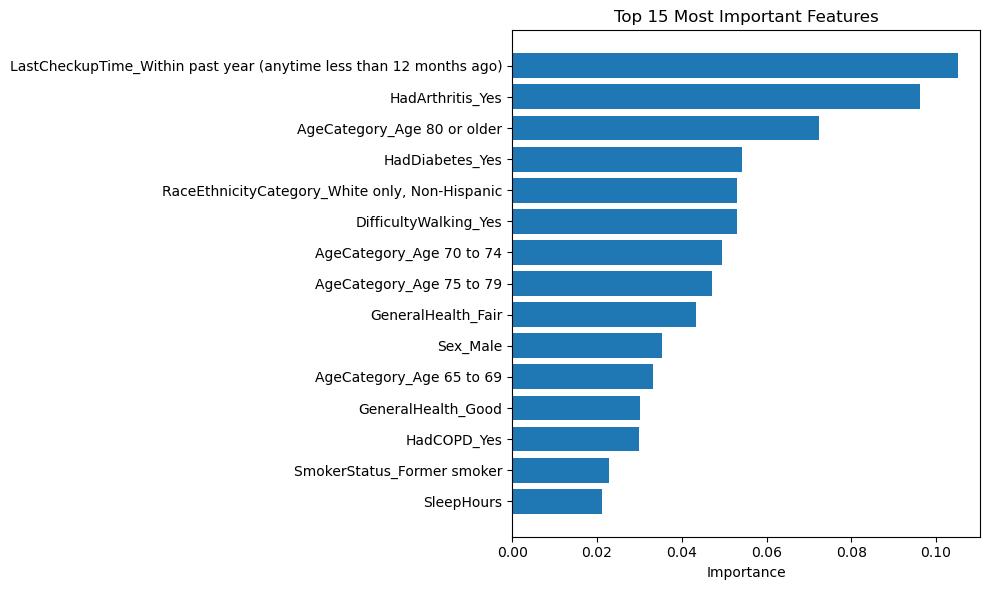

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on test set
y_pred = best_rf_model.predict(X_test_encoded)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No CVD', 'CVD'],
            yticklabels=['No CVD', 'CVD'])
plt.title('Confusion Matrix - Random Forest (Cost-Sensitive 1:5)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance - FIXED
feature_imp = pd.DataFrame({
    'Feature': X_train_encoded.columns,  # Changed from X_train
    'Importance': best_rf_model.named_steps['classifier'].feature_importances_  # Access through pipeline
}).sort_values('Importance', ascending=False).head(15)

print("\nTop 15 Features:")
print(feature_imp)

# Optional: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
pip install streamlit pandas numpy scikit-learn imbalanced-learn

In [14]:
import pickle
import os
from datetime import datetime

print("=" * 70)
print("SAVING OPTIMIZED MODELS (88.2% Recall)")
print("=" * 70)

# Check models exist
print(f"\nModel exists: {type(best_rf_model)}")
print(f"Class weight: {best_rf_model.named_steps['classifier'].class_weight}")

# Save models
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(best_lr_model, f)
print("\nSaved: lr_model.pkl")

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f)
print("Saved: rf_model.pkl")

feature_columns = X_train_encoded.columns.tolist()
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print(f"Saved: feature_columns.pkl ({len(feature_columns)} features)")

# Verify files
print("\nFile verification:")
for filename in ['lr_model.pkl', 'rf_model.pkl', 'feature_columns.pkl']:
    size = os.path.getsize(filename) / (1024*1024)
    timestamp = datetime.fromtimestamp(os.path.getmtime(filename))
    print(f"  {filename}:")
    print(f"    Size: {size:.2f} MB")
    print(f"    Modified: {timestamp}")

print("\n" + "=" * 70)
print("MODELS SAVED SUCCESSFULLY!")
print("Now restart your Streamlit app to use the new models")
print("=" * 70)

SAVING OPTIMIZED MODELS (88.2% Recall)

Model exists: <class 'imblearn.pipeline.Pipeline'>
Class weight: {0: 1, 1: 5}

Saved: lr_model.pkl
Saved: rf_model.pkl
Saved: feature_columns.pkl (49 features)

File verification:
  lr_model.pkl:
    Size: 14.61 MB
    Modified: 2025-11-11 20:16:27.271079
  rf_model.pkl:
    Size: 82.00 MB
    Modified: 2025-11-11 20:16:27.428736
  feature_columns.pkl:
    Size: 0.00 MB
    Modified: 2025-11-11 20:16:27.432733

MODELS SAVED SUCCESSFULLY!
Now restart your Streamlit app to use the new models


In [15]:
# Test the model directly
import pandas as pd

# Create a high-risk test case
test_patient = {
    'Sex': 'Male',
    'AgeCategory': 'Age 80 or older',
    'GeneralHealth': 'Poor',
    'PhysicalHealthDays': 30,
    'MentalHealthDays': 30,
    'LastCheckupTime': '5 or more years ago',
    'PhysicalActivities': 'No',
    'SleepHours': 4,
    'HadAsthma': 'Yes',
    'HadCOPD': 'Yes',
    'HadDepressiveDisorder': 'Yes',
    'HadKidneyDisease': 'Yes',
    'HadArthritis': 'Yes',
    'HadDiabetes': 'Yes',
    'DifficultyConcentrating': 'Yes',
    'DifficultyWalking': 'Yes',
    'DifficultyDressingBathing': 'Yes',
    'DifficultyErrands': 'Yes',
    'SmokerStatus': 'Current smoker - now smokes every day',
    'RaceEthnicityCategory': 'White only, Non-Hispanic',
    'HeightInMeters': 1.75,
    'WeightInKilograms': 100,
    'BMI': 32.65,
    'AlcoholDrinkers': 'Yes'
}

# Convert to DataFrame
test_df = pd.DataFrame([test_patient])

# One-hot encode
test_encoded = pd.get_dummies(test_df)

# Add missing columns
for col in X_train_encoded.columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Reorder
test_encoded = test_encoded[X_train_encoded.columns]

# Predict
rf_prob = best_rf_model.predict_proba(test_encoded)[0][1] * 100

print(f"Direct model prediction: {rf_prob:.1f}%")
print(f"Expected: 40-70% with 88.2% recall model")

Direct model prediction: 94.5%
Expected: 40-70% with 88.2% recall model
